### 사전작업

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/AI/covid data

/content/drive/MyDrive/AI/covid data


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 실행 후  메뉴에서 런타임 > 세션 다시 시작

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (22.5 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126371 files and direc

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')   # 나눔 바른 고딕 설정
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 1. 전처리

## 1-1 csv 내 정보 수정

In [ ]:
import numpy as np
import pandas as pd

# 엑셀 파일 불러오기
df = pd.read_csv('Covid Data.csv')

# 'DATE_DIED' 열의 값이 '9999-99-99'이면 0, 아니면 1으로 변경
df["DEATH"] = np.where(df["DATE_DIED"] == "9999-99-99", 0, 1)

# 필요없는 열 삭제
df = df.drop(['MEDICAL_UNIT','DATE_DIED', 'PATIENT_TYPE', 'USMER', 'INMSUPR', 'OTHER_DISEASE', 'PREGNANT'], axis=1)

# 'AGE' 열의 값이 91 이상인 모든 행을 삭제
df = df[df['AGE'] < 91]

# 'ICU', 'INTUBED' 97/98/99 값 -1(정보 없음)으로 변경
df["ICU"] = df["ICU"].replace({97: -1, 98: -1, 99: -1})
df["INTUBED"] = df["INTUBED"].replace({97: -1, 98: -1, 99: -1})

# 모든 열의 97, 98, 99 값을 pd.NA로 변경
df = df.replace({97: pd.NA, 98: pd.NA, 99: pd.NA})

# 'CLASIFFICATION_FINAL' 열의 값을 변경
df['CLASIFFICATION_FINAL'] = df['CLASIFFICATION_FINAL'].replace(list(range(1, 4)), 1)
df['CLASIFFICATION_FINAL'] = df['CLASIFFICATION_FINAL'].replace(list(range(4, 8)), 0)

# 'AGE' 열을 제외한 모든 열에서 2를 0으로 변경
columns_to_replace = [col for col in df.columns if col != 'AGE']
df[columns_to_replace] = df[columns_to_replace].replace({2: 0})

# NaN 값 제거
df = df.dropna()

## 1-2 모든 항목 숫자형(Int64)로 변경

In [ ]:
# 'object' 타입 열을 식별
object_cols = df.select_dtypes(include='object').columns

# 반복문을 통해 각 열을 숫자형으로 변환
for col in object_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

In [ ]:
df.head()

,SEX,INTUBED,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,HIPERTENSION,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DEATH
0,1,-1,1,65,0,0,0,1,0,0,0,0,1,-1,1
1,0,-1,1,72,0,0,0,1,0,1,1,0,0,-1,1
2,0,1,0,55,1,0,0,0,0,0,0,0,1,0,1
3,1,-1,0,53,0,0,0,0,0,0,0,0,0,-1,1
4,0,-1,0,68,1,0,0,1,0,0,0,0,1,-1,1


In [ ]:
print(len(df))

1024707


## 1-3 스케일링

In [ ]:
# Standard Scaling
# df['AGE'] = (df['AGE'] - df['AGE'].mean()) / df['AGE'].std()

In [ ]:
# MinMax Scaling
df['AGE'] = (df['AGE'] - df['AGE'].min()) / (df['AGE'].max() - df['AGE'].min())

In [ ]:
print(df['AGE'])

0          0.722222
1          0.800000
2          0.611111
3          0.588889
4          0.755556
             ...   
1048570    0.444444
1048571    0.566667
1048572    0.611111
1048573    0.311111
1048574    0.577778
Name: AGE, Length: 1024707, dtype: float64


In [ ]:
missing_values_count = df.isna().sum()

print(missing_values_count)

SEX                     0
INTUBED                 0
PNEUMONIA               0
AGE                     0
DIABETES                0
COPD                    0
ASTHMA                  0
HIPERTENSION            0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
DEATH                   0
dtype: int64


## 1-4 결측치 비율 확인

In [ ]:
# 전체 행의 개수
total_rows = len(df)

# 각 열별 결측치 비율 확인
missing_values_ratio = df.isna().sum() / total_rows

print(missing_values_ratio)

SEX                     0.0
INTUBED                 0.0
PNEUMONIA               0.0
AGE                     0.0
DIABETES                0.0
COPD                    0.0
ASTHMA                  0.0
HIPERTENSION            0.0
CARDIOVASCULAR          0.0
OBESITY                 0.0
RENAL_CHRONIC           0.0
TOBACCO                 0.0
CLASIFFICATION_FINAL    0.0
ICU                     0.0
DEATH                   0.0
dtype: float64


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1024707 entries, 0 to 1048574
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   SEX                   1024707 non-null  int64  
 1   INTUBED               1024707 non-null  int64  
 2   PNEUMONIA             1024707 non-null  Int64  
 3   AGE                   1024707 non-null  float64
 4   DIABETES              1024707 non-null  Int64  
 5   COPD                  1024707 non-null  Int64  
 6   ASTHMA                1024707 non-null  Int64  
 7   HIPERTENSION          1024707 non-null  Int64  
 8   CARDIOVASCULAR        1024707 non-null  Int64  
 9   OBESITY               1024707 non-null  Int64  
 10  RENAL_CHRONIC         1024707 non-null  Int64  
 11  TOBACCO               1024707 non-null  Int64  
 12  CLASIFFICATION_FINAL  1024707 non-null  int64  
 13  ICU                   1024707 non-null  int64  
 14  DEATH                 1024707 non-null 

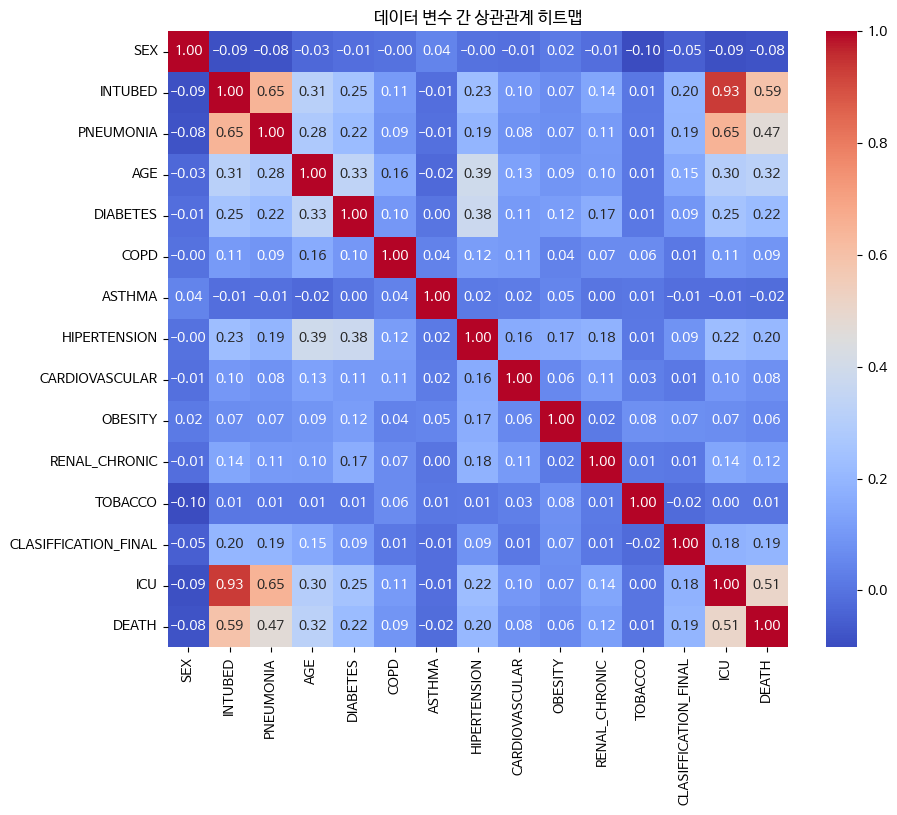

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터프레임의 모든 열 간의 상관관계 계산
correlation_matrix = df.corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("데이터 변수 간 상관관계 히트맵")
plt.show()

# 2. 머신러닝

## 2-1 코로나 확진자 중 심장 질환이 있는 환자들의 사망 확률 예측

In [ ]:
from sklearn.utils import resample
import pandas as pd

df_confirmed = df[df["CLASIFFICATION_FINAL"] == 1]

# 1. 클래스 분리
df_majority = df_confirmed[df_confirmed['DEATH'] == 0]  # 생존자 그룹
df_minority = df_confirmed[df_confirmed['DEATH'] == 1]  # 사망자 그룹

# 2. 생존자 데이터 샘플링
df_majority_undersampled = resample(df_majority,
                                     replace=False,    # 복원 추출(False)
                                     n_samples=len(df_minority), # 사망자 수만큼 샘플링
                                     random_state=42) # 재현성을 위한 시드값

# 3. 데이터 병합
df_undersampled = pd.concat([df_majority_undersampled, df_minority])

# 결과 확인
print("언더샘플링 후 데이터 크기:")
print(df_undersampled['DEATH'].value_counts())

언더샘플링 후 데이터 크기:
DEATH
0    53046
1    53046
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# 독립 변수(features) 지정
X = df_undersampled[[ 'SEX', 'AGE','CARDIOVASCULAR', 'HIPERTENSION', 'ICU']]

# 종속 변수(target) 지정
y = df_undersampled['DEATH']

# 훈련 및 테스트 세트 분할 (예: 8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 훈련 세트를 다시 훈련 및 검증 세트로 분할
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(f"훈련 세트 크기: {len(X_train)}")
print(f"검증 세트 크기: {len(X_val)}")
print(f"테스트 세트 크기: {len(X_test)}")

훈련 세트 크기: 63654
검증 세트 크기: 21219
테스트 세트 크기: 21219


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

# 모델 객체 생성
model = LogisticRegression()

# 훈련 데이터로 모델 학습
model.fit(X_train, y_train)

print("로지스틱 회귀 모델 학습 완료")

로지스틱 회귀 모델 학습 완료


In [ ]:
# 테스트 데이터로 예측 수행
predictions = model.predict(X_test)

# 정확도(Accuracy) 계산
accuracy = accuracy_score(y_test, predictions)

print(f"\n모델의 예측 정확도: {accuracy:.4f}")


모델의 예측 정확도: 0.8543


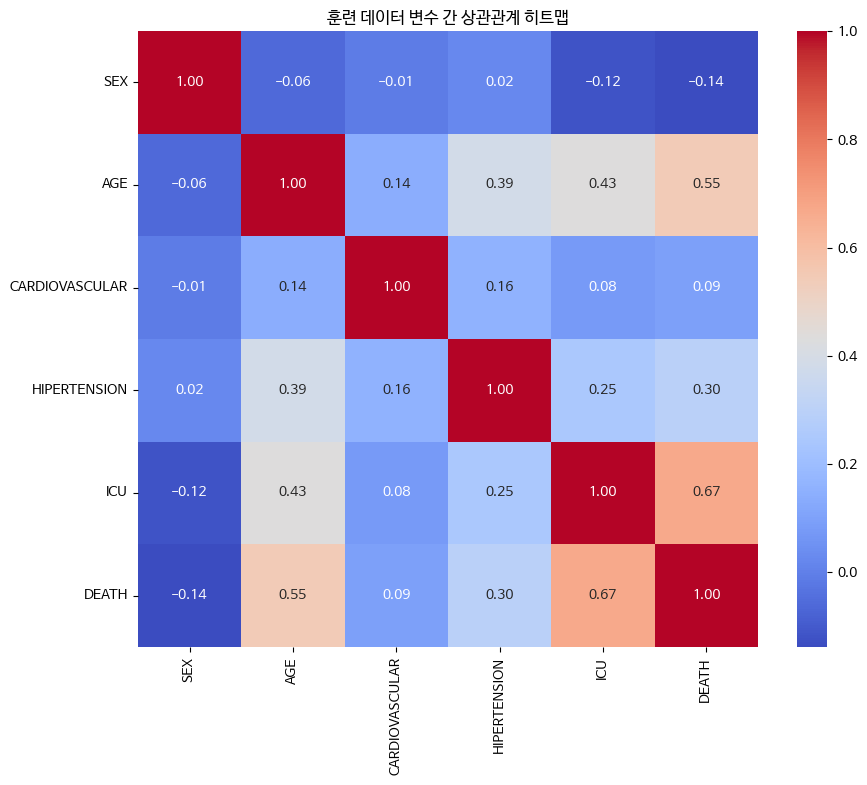

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

train_data = pd.concat([X_train, y_train], axis=1)

# 합쳐진 데이터프레임의 모든 열 간의 상관관계 계산
correlation_matrix = train_data.corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("훈련 데이터 변수 간 상관관계 히트맵")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85     10712
           1       0.84      0.87      0.86     10507

    accuracy                           0.85     21219
   macro avg       0.85      0.85      0.85     21219
weighted avg       0.85      0.85      0.85     21219



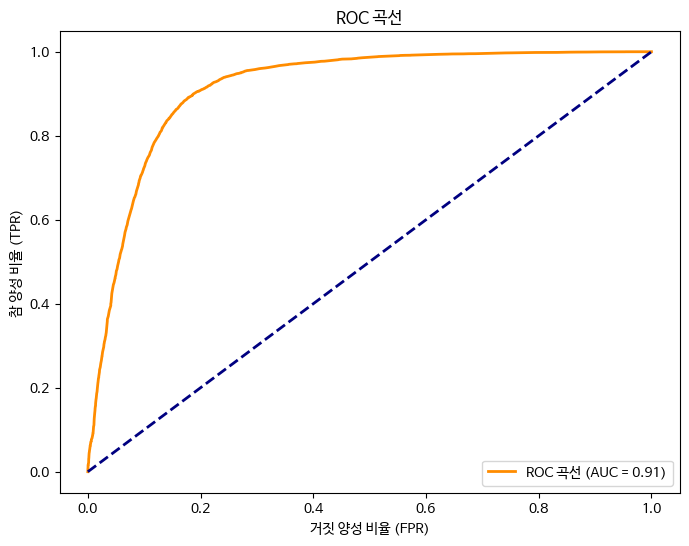

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC 곡선 (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('거짓 양성 비율 (FPR)')
plt.ylabel('참 양성 비율 (TPR)')
plt.title('ROC 곡선')
plt.legend(loc="lower right")
plt.show()

최초 독립 변수를 심질환과 고혈압 2개로 설정하고 학습 시 낮은 정확도 및 재현율을 보였음
모델 개선을 위해 데이터 간 상관관계 그래프를 통해 관련 변수를 확인하여 독립 변수를 추가하고 데이터 불균형을 언더샘플링을 통해 수정함
이후 모델 개선이 성공적으로 되어 ROC 그래프를 통해 확인함

## 2-2 합병증이 있는 사람들의 코로나 확진 확률 예측

In [ ]:
# 데이터 불균형 확인
print(df['CLASIFFICATION_FINAL'].value_counts())

CLASIFFICATION_FINAL
0    635956
1    388751
Name: count, dtype: int64


### 오버샘플링

In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd
from collections import Counter

# 독립 변수(features) 지정
X = df[['DIABETES', 'COPD', 'ASTHMA', 'HIPERTENSION', 'CARDIOVASCULAR',
        'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'PNEUMONIA']]

# X의 데이터 타입을 float로 변환 (SMOTE 오류 방지)
X = X.astype(float)

# 종속 변수(target) 지정
y = df['CLASIFFICATION_FINAL']

print("SMOTE 적용 전 데이터 크기:")
print(Counter(y))

# SMOTE 객체 생성 및 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nSMOTE 적용 후 데이터 크기:")
print(Counter(y_resampled))

SMOTE 적용 전 데이터 크기:
Counter({0: 635956, 1: 388751})


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# 훈련 및 테스트 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 훈련 세트를 다시 훈련 및 검증 세트로 분할
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(f"훈련 세트 크기: {len(X_train)}")
print(f"검증 세트 크기: {len(X_val)}")
print(f"테스트 세트 크기: {len(X_test)}")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

# 모델 객체 생성
model = LogisticRegression()

# 훈련 데이터로 모델 학습
model.fit(X_train, y_train)

print("로지스틱 회귀 모델 학습 완료")

In [ ]:
# 테스트 데이터로 예측 수행
predictions = model.predict(X_test)

# 정확도(Accuracy) 계산
accuracy = accuracy_score(y_test, predictions)

print(f"\n모델의 예측 정확도: {accuracy:.4f}")

In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

- 하이퍼파라미터 확인

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# 튜닝할 하이퍼파라미터 정의
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1')

# 훈련 데이터로 탐색 시작
grid_search.fit(X_train, y_train)

print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최고 F1 점수:", grid_search.best_score_)

NameError: name 'X_train' is not defined

- Random forest 모델로 학습

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 모델 객체 생성
model = RandomForestClassifier(n_estimators=100, random_state=42)

# 훈련 데이터로 모델 학습
model.fit(X_train, y_train)

# 테스트 데이터로 예측 및 성능 평가
predictions = model.predict(X_test)
print("랜덤 포레스트 모델 성능:")
print(classification_report(y_test, predictions))

accuracy = accuracy_score(y_test, predictions)
print(f"\n모델의 예측 정확도: {accuracy:.4f}")

랜덤 포레스트 모델 성능:
              precision    recall  f1-score   support

           0       0.56      0.72      0.63     77638
           1       0.62      0.44      0.51     77863

    accuracy                           0.58    155501
   macro avg       0.59      0.58      0.57    155501
weighted avg       0.59      0.58      0.57    155501


모델의 예측 정확도: 0.5827


### 언더샘플링

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
from collections import Counter

# 독립 변수(features) 지정
X = df[['DIABETES', 'COPD', 'ASTHMA', 'HIPERTENSION', 'CARDIOVASCULAR',
        'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'PNEUMONIA', 'AGE', 'SEX']]

# 종속 변수(target) 지정
y = df['CLASIFFICATION_FINAL']

print("언더샘플링 적용 전 데이터 크기:")
print(Counter(y))

# RandomUnderSampler 객체 생성 및 적용
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print("\n언더샘플링 적용 후 데이터 크기:")
print(Counter(y_resampled))

언더샘플링 적용 전 데이터 크기:
Counter({0: 635956, 1: 388751})

언더샘플링 적용 후 데이터 크기:
Counter({0: 388751, 1: 388751})


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# 훈련 및 테스트 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 훈련 세트를 다시 훈련 및 검증 세트로 분할
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(f"훈련 세트 크기: {len(X_train)}")
print(f"검증 세트 크기: {len(X_val)}")
print(f"테스트 세트 크기: {len(X_test)}")

훈련 세트 크기: 466500
검증 세트 크기: 155501
테스트 세트 크기: 155501


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

# 모델 객체 생성
model = LogisticRegression()

# 훈련 데이터로 모델 학습
model.fit(X_train, y_train)

print("로지스틱 회귀 모델 학습 완료")

로지스틱 회귀 모델 학습 완료


In [ ]:
# 테스트 데이터로 예측 수행
predictions = model.predict(X_test)

# 정확도 계산
accuracy = accuracy_score(y_test, predictions)

print(f"\n모델의 예측 정확도: {accuracy:.4f}")


모델의 예측 정확도: 0.5862


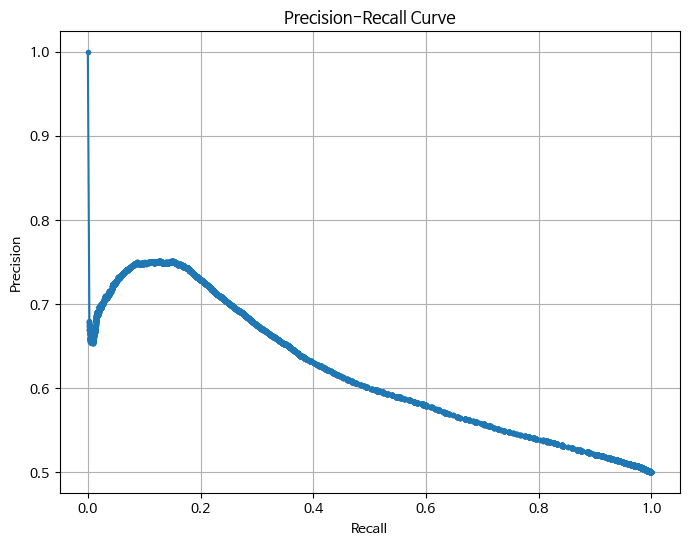

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

y_scores = model.predict_proba(X_test)[:, 1]

# 정밀도-재현율 곡선 계산
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# 시각화
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

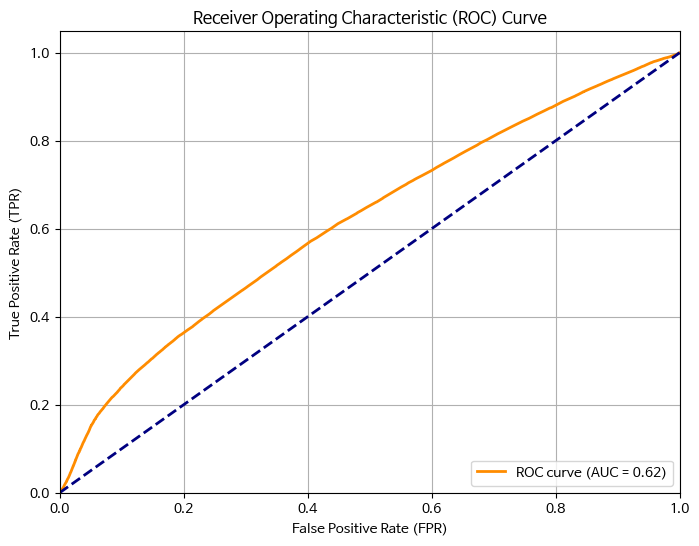

모델의 ROC-AUC 값: 0.6180


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_scores = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# AUC 계산
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"모델의 ROC-AUC 값: {roc_auc:.4f}")

In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.57      0.71      0.63     77638
           1       0.62      0.46      0.53     77863

    accuracy                           0.59    155501
   macro avg       0.59      0.59      0.58    155501
weighted avg       0.59      0.59      0.58    155501



오버 샘플링 시 결과
              precision    recall  f1-score   support

           0       0.56      0.77      0.65    127212
           1       0.63      0.39      0.48    127171

    accuracy                           0.58    254383
   macro avg       0.59      0.58      0.57    254383
weighted avg       0.59      0.58      0.57    254383

언더 샘플링 시 결과
              precision    recall  f1-score   support

           0       0.57      0.71      0.63     77638
           1       0.62      0.46      0.53     77863

    accuracy                           0.59    155501
   macro avg       0.59      0.59      0.58    155501
weighted avg       0.59      0.59      0.58    155501

재현율과 f1스코어는 미세하게 상승하였으나 정확도는 크게 개선되지 않아 현재 데이터의 한계라고 보여짐

아래 히트맵 확인 결과 코로나 확진과 관련된 카테고리들이 상관관계가 거의 없었음

## 2-3 코로나 확진자 중 인공호흡기 사용 예측

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 'CLASIFFICATION_FINAL'이 1인(코로나 확진자) 데이터만 필터링
df_filtered = df[(df['CLASIFFICATION_FINAL'] == 1) & (df['INTUBED'] != -1)]

# 독립 변수(features) 지정
# INTUBED와 상관관계가 높은 변수들 선택
X = df_filtered[['PNEUMONIA', 'AGE', 'HIPERTENSION', 'DIABETES', 'DEATH']]

# 종속 변수(target) 지정
y = df_filtered['INTUBED']

In [ ]:
print("SMOTE 적용 전 데이터 크기:")
print(Counter(y))

# SMOTE 객체 생성 및 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nSMOTE 적용 후 데이터 크기:")
print(Counter(y_resampled))

SMOTE 적용 전 데이터 크기:
Counter({0: 84794, 1: 23300})

SMOTE 적용 후 데이터 크기:
Counter({1: 84794, 0: 84794})


In [ ]:
# 훈련 및 테스트 세트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# RandomForestClassifier 모델 객체 생성 및 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 테스트 데이터로 예측 및 성능 평가
predictions = model.predict(X_test)
print("\n랜덤 포레스트 모델 성능:")
print(classification_report(y_test, predictions))


랜덤 포레스트 모델 성능:
              precision    recall  f1-score   support

           0       0.81      0.69      0.75     16951
           1       0.73      0.84      0.78     16967

    accuracy                           0.77     33918
   macro avg       0.77      0.77      0.77     33918
weighted avg       0.77      0.77      0.77     33918



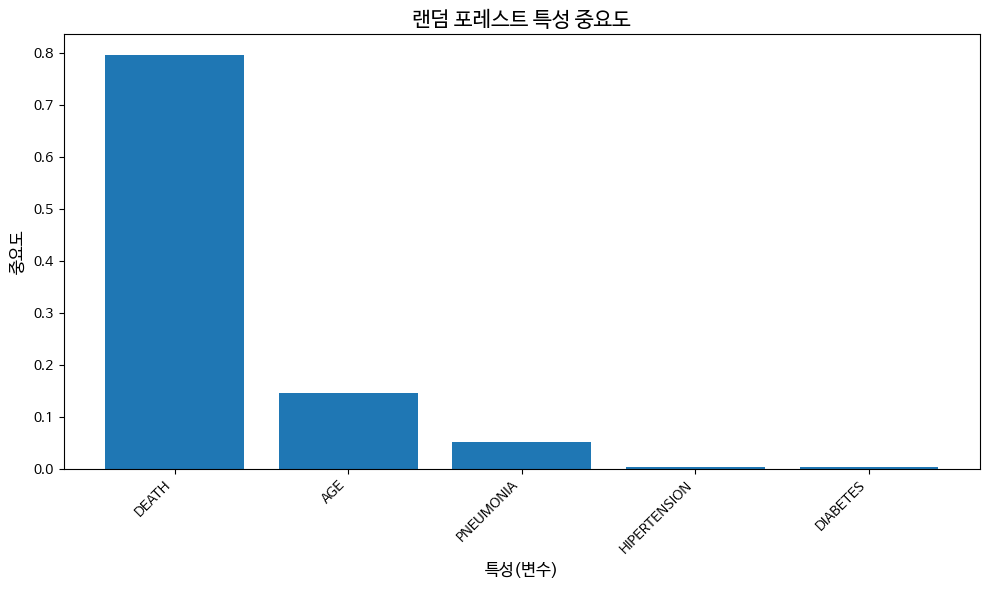

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

importances = model.feature_importances_

feature_names = X_train.columns

sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# 그래프 시각화
plt.figure(figsize=(10, 6))

# 막대 그래프 그리기
plt.bar(range(X_train.shape[1]), sorted_importances, align='center')

# x축 레이블 설정
plt.xticks(range(X_train.shape[1]), sorted_feature_names, rotation=45, ha='right')

# 그래프 제목 및 레이블
plt.title("랜덤 포레스트 특성 중요도", fontsize=15)
plt.xlabel("특성(변수)", fontsize=12)
plt.ylabel("중요도", fontsize=12)
plt.tight_layout()
plt.show()

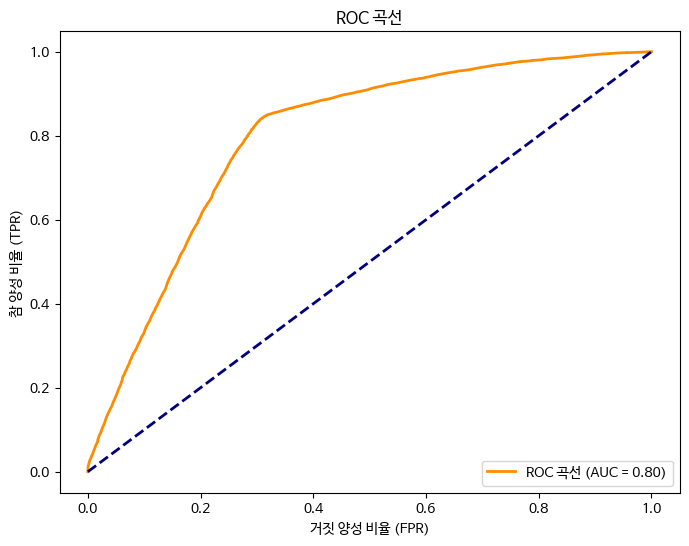

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC 곡선 (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('거짓 양성 비율 (FPR)')
plt.ylabel('참 양성 비율 (TPR)')
plt.title('ROC 곡선')
plt.legend(loc="lower right")
plt.show()

오버샘플링을 통해 데이터 균형 확인 및 랜덤포레스트 모델을 사용해서 모델 학습 결과 재현율이 높게 나와 중요도 및 ROC 확인